# Resolving Class Imbalance with Augmentation for single recording 

In [1]:
import numpy as np
import mne
from scipy import signal
from scipy.interpolate import RectBivariateSpline
from mne.filter import resample, filter_data
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from lspopt import spectrogram_lspopt
from matplotlib.colors import Normalize, ListedColormap

import logging
LOGGING_TYPES = dict(DEBUG=logging.DEBUG, INFO=logging.INFO, WARNING=logging.WARNING,
                     ERROR=logging.ERROR, CRITICAL=logging.CRITICAL)
logger = logging.getLogger('yasa')

# %matplotlib qt


In [2]:
# load reference_df     
reference_df = pd.read_csv("reference_df.csv", index_col="name")
reference_df.head(3)

,hypno,df_feat,eeg
name,,,
P18_N3 L,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P18_N3 L.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...
P18_N2 R,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P18_N2 R.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...
P17_N2 L,/Users/amirhosseindaraie/Desktop/data/synced-h...,feature/P17_N2 L.csv,/Users/amirhosseindaraie/Desktop/data/autoscor...


In [3]:
# load csv
rankings_df = pd.read_csv("rankings_df.csv", index_col="method_name")
rankings_df.head(3)


,sb,ab,bs,ag,sg,gs,ba,ta_b,alpha,ga,...,mean_psd,kurt,E,WEn,renyi,mean_distance,diffEnt,skew,tsallisEnt,mean
method_name,,,,,,,,,,,,,,,,,,,,,
f_classif,1.0,2.0,3.0,4.0,5.0,10.0,11.0,6.0,7.0,22.0,...,66.0,72.0,67.0,69.0,70.0,65.0,71.0,73.0,74.0,75.0
MI,1.0,2.0,3.0,4.0,8.0,9.0,5.0,7.0,17.0,6.0,...,70.0,67.0,73.0,68.0,71.0,74.0,72.0,66.0,69.0,75.0
chiSqr,2.0,1.0,3.0,6.0,9.0,4.0,8.0,16.0,5.0,7.0,...,66.0,64.0,67.0,71.0,68.0,72.0,69.0,73.0,74.0,75.0


Count the number of epochs in all recordings. Please note that artifact epochs are omitted. 

46713 epochs available across 61 recordings.


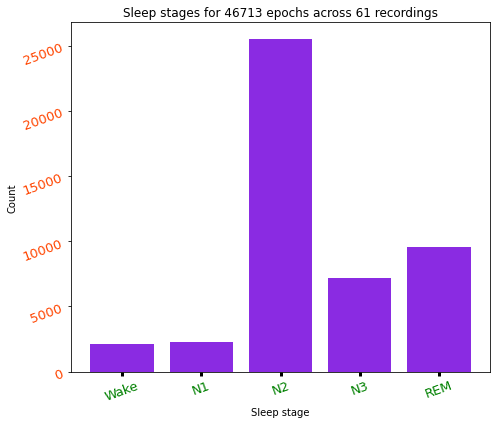

In [4]:
### to see id's
idx = reference_df.index.to_list()

epochs_count = 0
hypno_30s_all = np.array([])

# to loop over all recording files:
for i in idx:
    # to load hypno:
    hypno_loc = reference_df.loc[i, "hypno"]
    hypno_30s = np.loadtxt(hypno_loc, dtype="int")[:, 0]
    # to omit artifcat epochs
    hypno_30s = hypno_30s[hypno_30s != -1]
    # to change 5 to 4 in socrings that assigned 5 to REM instead of 4:
    hypno_30s[hypno_30s == 5] = 4
    # to append current hypno to array of all hypnos - to plotting histogram later:
    hypno_30s_all = np.append(hypno_30s_all, hypno_30s)
    # count the number of epochs
    epochs_count += len(hypno_30s)

print(f"{epochs_count} epochs available across {len(idx)} recordings.")

# plotting histogram of classes in all hypnos:
stages, counts = np.unique(hypno_30s_all, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(stages, counts, color="blueviolet")
ax.set(xticks=np.arange(0, 4 + 1, 1), xticklabels=["Wake", "N1", "N2", "N3", "REM"])
ax.tick_params(axis="x", labelsize=13, labelrotation=20, labelcolor="green", width=3)
ax.tick_params(axis="y", labelsize=13, labelrotation=20, labelcolor="orangered")
plt.xlabel("Sleep stage")
plt.ylabel("Count")
plt.title(f"Sleep stages for {epochs_count} epochs across {len(idx)} recordings")
plt.tight_layout()
# plt.savefig("stage_distribution_count.svg")
# plt.savefig("stage_distribution_count.png")
plt.show()


In [5]:
def sliding_window(data, sf, window, step=None, axis=-1):
    """Calculate a sliding window of a 1D or 2D EEG signal.
    .. versionadded:: 0.1.7
    Parameters
    ----------
    data : numpy array
        The 1D or 2D EEG data.
    sf : float
        The sampling frequency of ``data``.
    window : int
        The sliding window length, in seconds.
    step : int
        The sliding window step length, in seconds.
        If None (default), ``step`` is set to ``window``,
        which results in no overlap between the sliding windows.
    axis : int
        The axis to slide over. Defaults to the last axis.
    Returns
    -------
    times : numpy array
        Time vector, in seconds, corresponding to the START of each sliding
        epoch in ``strided``.
    strided : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window, shape (n_epochs, ..., n_samples).
    Notes
    -----
    This is a wrapper around the
    :py:func:`numpy.lib.stride_tricks.as_strided` function.
    Examples
    --------
    With a 1-D array
    >>> import numpy as np
    >>> from yasa import sliding_window
    >>> data = np.arange(20)
    >>> times, epochs = sliding_window(data, sf=1, window=5)
    >>> times
    array([ 0.,  5., 10., 15.])
    >>> epochs
    array([[ 0,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9],
        [10, 11, 12, 13, 14],
        [15, 16, 17, 18, 19]])
    >>> sliding_window(data, sf=1, window=5, step=1)[1]
    array([[ 0,  1,  2,  3,  4],
        [ 2,  3,  4,  5,  6],
        [ 4,  5,  6,  7,  8],
        [ 6,  7,  8,  9, 10],
        [ 8,  9, 10, 11, 12],
        [10, 11, 12, 13, 14],
        [12, 13, 14, 15, 16],
        [14, 15, 16, 17, 18]])
    >>> sliding_window(data, sf=1, window=11)[1]
    array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]])
    With a N-D array
    >>> np.random.seed(42)
    >>> # 4 channels x 20 samples
    >>> data = np.random.randint(-100, 100, size=(4, 20))
    >>> epochs = sliding_window(data, sf=1, window=10)[1]
    >>> epochs.shape  # shape (n_epochs, n_channels, n_samples)
    (2, 4, 10)
    >>> epochs
    array([[[  2,  79,  -8, -86,   6, -29,  88, -80,   2,  21],
            [-13,  57, -63,  29,  91,  87, -80,  60, -43, -79],
            [-50,   7, -46, -37,  30, -50,  34, -80, -28,  66],
            [ -9,  10,  87,  98,  71, -93,  74, -66, -20,  63]],
        [[-26, -13,  16,  -1,   3,  51,  30,  49, -48, -99],
            [-12, -52, -42,  69,  87, -86,  89,  89,  74,  89],
            [-83,  31, -12, -41, -87, -92, -11, -48,  29, -17],
            [-51,   3,  31, -99,  33, -47,   5, -97, -47,  90]]])
    """
    from numpy.lib.stride_tricks import as_strided

    assert axis <= data.ndim, "Axis value out of range."
    assert isinstance(sf, (int, float)), "sf must be int or float"
    assert isinstance(window, (int, float)), "window must be int or float"
    assert isinstance(step, (int, float, type(None))), (
        "step must be int, " "float or None."
    )
    if isinstance(sf, float):
        assert sf.is_integer(), "sf must be a whole number."
        sf = int(sf)
    assert isinstance(axis, int), "axis must be int."

    # window and step in samples instead of points
    window *= sf
    step = window if step is None else step * sf

    if isinstance(window, float):
        assert window.is_integer(), "window * sf must be a whole number."
        window = int(window)

    if isinstance(step, float):
        assert step.is_integer(), "step * sf must be a whole number."
        step = int(step)

    assert step >= 1, "Stepsize may not be zero or negative."
    assert window < data.shape[axis], (
        "Sliding window size may not exceed " "size of selected axis"
    )

    # Define output shape
    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / step - window / step + 1).astype(int)
    shape.append(window)

    # Calculate strides and time vector
    strides = list(data.strides)
    strides[axis] *= step
    strides.append(data.strides[axis])
    strided = as_strided(data, shape=shape, strides=strides)
    t = np.arange(strided.shape[-2]) * (step / sf)

    # Swap axis: n_epochs, ..., n_samples
    if strided.ndim > 2:
        strided = np.rollaxis(strided, -2, 0)
    return t, strided


# Augmentation for single night 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 1691 samples (6.605 sec)



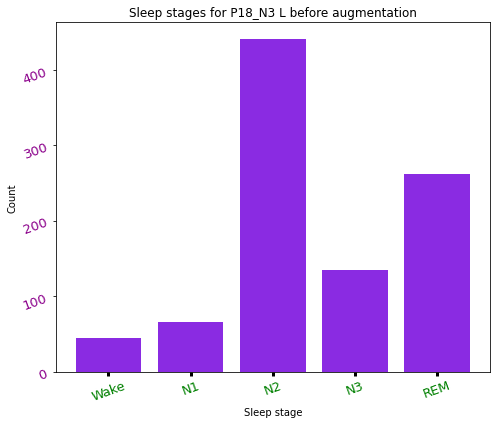

Stages count for P18_N3 L is as follow:
[0. 1. 2. 3. 4.] [ 45  66 441 135 262]


In [6]:
# to load information of each night:
name = reference_df.iloc[0].name
hypno_30s_loc = reference_df.iloc[0].hypno
df_feat_loc = reference_df.iloc[0].df_feat
eeg_loc = reference_df.iloc[0].eeg

# to load data of each night:
hypno_30s = np.loadtxt(hypno_30s_loc)[:, 0]
df_feat = pd.read_csv(df_feat_loc, index_col=False)
raw = mne.io.read_raw_edf(eeg_loc, preload=True, verbose=0)
raw.pick_types(eeg=True)
sf = raw.info["sfreq"]
raw.filter(0.5, 45)
data = raw._data * 1e6  # : extract the data and convert from V to uV

# plotting histogram of classes in this night:
stages, counts = np.unique(hypno_30s, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(stages, counts, color="blueviolet")
ax.set(xticks=np.arange(0, 4 + 1, 1), xticklabels=["Wake", "N1", "N2", "N3", "REM"])
ax.tick_params(axis="x", labelsize=13, labelrotation=20, labelcolor="green", width=3)
ax.tick_params(axis="y", labelsize=13, labelrotation=20, labelcolor="darkmagenta")
plt.xlabel("Sleep stage")
plt.ylabel("Count")
plt.title(f"Sleep stages for {name} before augmentation")
plt.tight_layout()
# plt.savefig(f"stage_distribution_count {name} before aug.svg")
# plt.savefig(f"stage_distribution_count {name} before aug.png")
plt.show()

times = np.arange(data.size) / sf  # : time vector in seconds
times, data_win = sliding_window(
    data[0], sf, window=30
)  # : convert the EEG data to 30-sec data
times /= 60  # : convert times to minutes

# to filter artifact epochs in each night:
data_win = data_win[hypno_30s != -1, :]
df_feat = df_feat.loc[hypno_30s != -1]
hypno_30s = hypno_30s[hypno_30s != -1]

# to see the class imbalance:
stages, counts = np.unique(
    hypno_30s, return_counts=True
)  # to see class balance of each night:

print(f"Stages count for {name} is as follow:")
print(stages, counts)


In [7]:
def augment_data(
    class_to_augment=0, data_win=data_win, hypno_30s=hypno_30s, name="Subject [ ]"
):
    """
    This function augments the epochs with class `class_to_augment` (int) in `data_win` (matrix) until the count of `class_to_augment` reaches the count of dominate class in that sleep session. It returns the new augmented matrix `data_win_aug` and the new hypnogram `hypno_30s_aug`.

    Parameters
    ----------
    class_to_augment : int
        The class number that we want to augment
    data_win : numpy array (matrix)
        The `data_win` matrix that contains n epochs (rows) and each epoch 30 seconds of data (columns). The size is `(epochs x datapoints)` usually `(800,7680)`.
    hypno_30s : numpy array (vector)
        The hypnogram associated with `data_win`. This is usually in the size if `(epochs,)`.
    name: str, optional
        Subject name

    Returns
    -------
    data_win_aug:
        Augmented data_win that has size of `(augmented_epochs x datapoints)`.
    hypno_30s_aug
        Augmented hypno_30s that is in the size of `(augmented_epochs,)`.
    """
    data_win_aug = np.array([])
    hypno_30s_aug = np.array([])
    method_used = 0
    dominate_class_count = np.max(counts)
    current_class_count = data_win[hypno_30s == class_to_augment].shape[0]

    if current_class_count < dominate_class_count * 0.9:
        while current_class_count < dominate_class_count * 0.9:
            if method_used == 0:
                # here we inverse the signal from end to start : 1 -> 1'
                augmented_win = data_win[hypno_30s == class_to_augment][:, ::-1]
                data_win_aug = np.vstack([data_win, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 1:
                #  here we divide signal into 2 : 1,2 -> 2,1
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 2)]
                part2_win = data_win[hypno_30s == class_to_augment][:, int(7680 / 2) :]
                augmented_win = np.hstack([part2_win, part1_win])
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 2:
                #  here we divide signal into 2 : 1,2 -> 2',1'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 2)]
                part2_win = data_win[hypno_30s == class_to_augment][:, int(7680 / 2) :]
                augmented_win = np.hstack([part2_win[:, ::-1], part1_win[:, ::-1]])
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 3:
                #  here we divide signal into 3 : 1,2,3 -> 3,1,2
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part3_win[:, :], part1_win[:, :], part2_win[:, :]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 4:
                #  here we divide signal into 3 : 1,2,3 -> 3',1',2'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part3_win[:, ::-1], part1_win[:, ::-1], part2_win[:, ::-1]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 5:
                # here we divide signal into 3 : 1,2,3 -> 2,3,1
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part2_win[:, :], part3_win[:, :], part1_win[:, :]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 6:
                # here we divide signal into 3 : 1,2,3 -> 2',3',1'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part2_win[:, ::-1], part3_win[:, ::-1], part1_win[:, ::-1]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 7:
                # here we divide signal into 3 : 1,2,3 -> 3,2,1
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part3_win[:, :], part2_win[:, :], part1_win[:, :]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 8:
                # here we divide signal into 3 : 1,2,3 -> 3',2',1'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part3_win[:, ::-1], part2_win[:, ::-1], part1_win[:, ::-1]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 9:
                # here we divide signal into 3 : 1,2,3 -> 1',3',2'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part1_win[:, ::-1], part3_win[:, ::-1], part2_win[:, ::-1]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 10:
                # here we divide signal into 3 : 1,2,3 -> 1',2',3'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 3)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3) : int(7680 / 3 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 3 * 2) :
                ]
                augmented_win = np.hstack(
                    [part1_win[:, ::-1], part2_win[:, ::-1], part3_win[:, ::-1]]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 11:
                # here we divide signal into 4 : 1,2,3,4 -> 4,3,2,1
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 4)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4) : int(7680 / 4 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4 * 2) : int(7680 / 4 * 3)
                ]
                part4_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4 * 3) :
                ]
                augmented_win = np.hstack(
                    [
                        part4_win[:, ::-1],
                        part3_win[:, :],
                        part2_win[:, :],
                        part1_win[:, :],
                    ]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            elif method_used == 12:
                # here we divide signal into 4 : 1,2,3,4 -> 4',3',2',1'
                part1_win = data_win[hypno_30s == class_to_augment][:, : int(7680 / 4)]
                part2_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4) : int(7680 / 4 * 2)
                ]
                part3_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4 * 2) : int(7680 / 4 * 3)
                ]
                part4_win = data_win[hypno_30s == class_to_augment][
                    :, int(7680 / 4 * 3) :
                ]
                augmented_win = np.hstack(
                    [
                        part4_win[:, ::-1],
                        part3_win[:, ::-1],
                        part2_win[:, ::-1],
                        part1_win[:, ::-1],
                    ]
                )
                data_win_aug = np.vstack([data_win_aug, augmented_win])
                hypno_30s_aug = np.append(
                    hypno_30s_aug, np.ones(augmented_win.shape[0]) * class_to_augment
                )
                method_used += 1

            else:
                break

            current_class_count = data_win_aug[hypno_30s_aug == class_to_augment].shape[
                0
            ]

    else:
        data_win_aug = data_win
        hypno_30s_aug = hypno_30s

    print(f">> Feature augmentation @ {name} Class {class_to_augment} ")
    print(f"curr: {current_class_count}, domin: {dominate_class_count}")
    return data_win_aug, hypno_30s_aug


def augment_data_wrapper(data_win=data_win, hypno_30s=hypno_30s, name="Subject [ ]"):
    """
    This function is a wrapper for `augment_data` function. The main idea is to repeat `augment_data` function for all classes and output an augmented `data_win`.

    Parameters
    ----------
    data_win : numpy array (matrix)
        The `data_win` matrix that contains n epochs (rows) and each epoch 30 seconds of data (columns). The size is `(epochs x datapoints)` usually `(800,7680)`.
    hypno_30s : numpy array (vector)
        The hypnogram associated with `data_win`. This is usually in the size if `(epochs,)`.
    name: str, optional
        Subject name

    Returns
    -------
    data_win_aug:
        Augmented data_win that has size of `(augmented_epochs x datapoints)`.
    hypno_30s_aug
        Augmented hypno_30s that is in the size of `(augmented_epochs,)`.
    """
    data_win_aug, hypno_30s_aug = augment_data(0, data_win, hypno_30s, name)
    data_win_aug, hypno_30s_aug = augment_data(1, data_win_aug, hypno_30s_aug, name)
    data_win_aug, hypno_30s_aug = augment_data(2, data_win_aug, hypno_30s_aug, name)
    data_win_aug, hypno_30s_aug = augment_data(3, data_win_aug, hypno_30s_aug, name)
    data_win_aug, hypno_30s_aug = augment_data(4, data_win_aug, hypno_30s_aug, name)
    return data_win_aug, hypno_30s_aug


# Augment data_win:
data_win_aug, hypno_30s_aug = augment_data_wrapper(data_win, hypno_30s, name=name)

# Save augmented data to same location as data (EEG & hypno). Only add " aug" to their end.
np.savetxt(eeg_loc.split(".")[0] + " aug.txt", data_win_aug, delimiter=",")

textfile = open(hypno_30s_loc.split(".")[0] + " aug.txt", "w")
for element in hypno_30s_aug:
    textfile.write(f"{int(element)}" + "\n")
textfile.close()

print(eeg_loc.split(".")[0] + " aug.csv")
print(hypno_30s_loc.split(".")[0] + " aug.txt")


>> Feature augmentation @ P18_N3 L Class 0 
curr: 405, domin: 441
>> Feature augmentation @ P18_N3 L Class 1 
curr: 462, domin: 441
>> Feature augmentation @ P18_N3 L Class 2 
curr: 441, domin: 441
>> Feature augmentation @ P18_N3 L Class 3 
curr: 405, domin: 441
>> Feature augmentation @ P18_N3 L Class 4 
curr: 524, domin: 441
/Users/amirhosseindaraie/Desktop/data/autoscoring-material/data/Zmax Donders/P18_N3/EEG L aug.csv
/Users/amirhosseindaraie/Desktop/data/synced-hypnos-merged/p18n3_synced aug.txt


Plotting histogram of classes in this night:

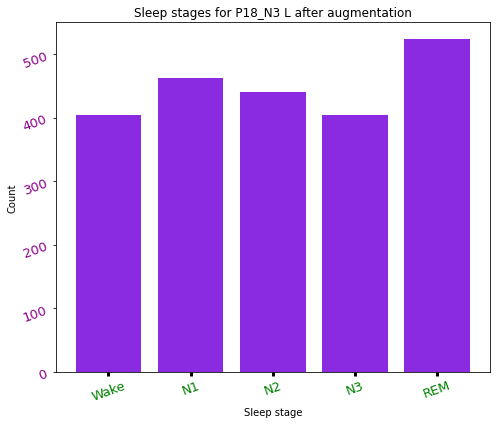

In [8]:
stages, counts = np.unique(hypno_30s_aug, return_counts=True)

fig, ax = plt.subplots(figsize=(7, 6))
ax.bar(stages, counts, color="blueviolet")
ax.set(xticks=np.arange(0, 4 + 1, 1), xticklabels=["Wake", "N1", "N2", "N3", "REM"])
ax.tick_params(axis="x", labelsize=13, labelrotation=20, labelcolor="green", width=3)
ax.tick_params(axis="y", labelsize=13, labelrotation=20, labelcolor="darkmagenta")
plt.xlabel("Sleep stage")
plt.ylabel("Count")
plt.title(f"Sleep stages for {name} after augmentation")
plt.tight_layout()
plt.savefig(f"stage_distribution_count {name} after aug.svg")
plt.savefig(f"stage_distribution_count {name} after aug.png")
plt.show()

Plot different augmentation methods that we used to synthesize EEG data

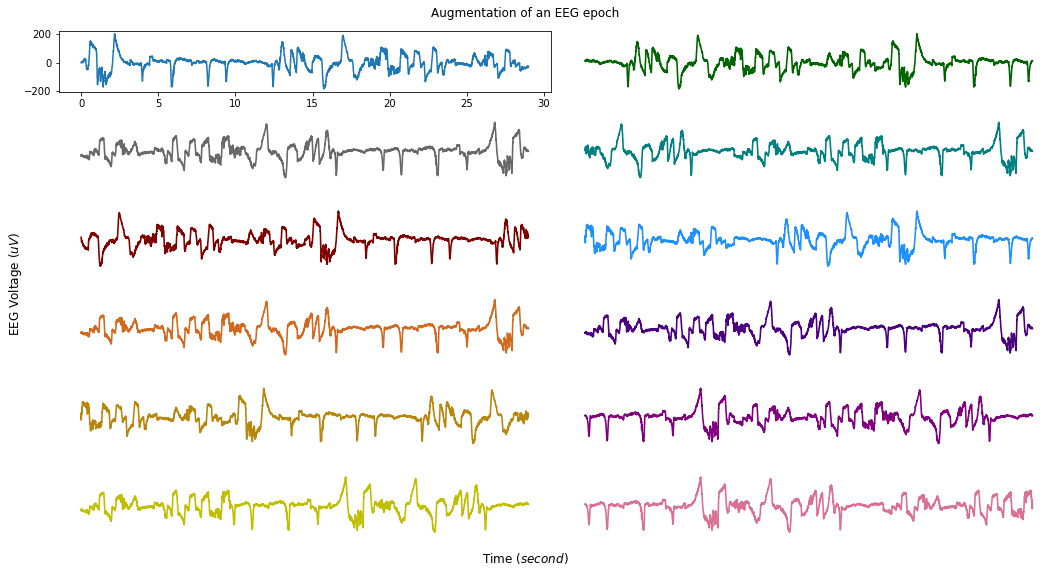

In [9]:
fig, axes = plt.subplots(6, 2, figsize=(15, 8))
# Orginal Signal
axes[0, 0].plot(np.linspace(0,7680/265,7680),data_win[hypno_30s == 0][0, :])
# Method 0
augmented_win = data_win[hypno_30s == 0][0, ::-1]
axes[1, 0].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="dimgrey")
# Method 1
part1_win = data_win[hypno_30s == 0][0, : int(7680 / 2)]
part2_win = data_win[hypno_30s == 0][0, int(7680 / 2) :]
augmented_win = np.hstack([part2_win, part1_win])
axes[2, 0].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="maroon")
# Method 2
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 2)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 2) :]
augmented_win = np.hstack([part2_win[0, ::-1], part1_win[0, ::-1]])
axes[3, 0].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="chocolate")
# Method 3
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part3_win[0, :], part1_win[0, :], part2_win[0, :]])
axes[4, 0].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="darkgoldenrod")
# Method 4
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part3_win[0, ::-1], part1_win[0, ::-1], part2_win[0, ::-1]])
axes[5, 0].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="y")
# Method 5
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part2_win[0, :], part3_win[0, :], part1_win[0, :]])
axes[0, 1].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="darkgreen")
# Method 6
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part2_win[0, ::-1], part3_win[0, ::-1], part1_win[0, ::-1]])
axes[1, 1].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="teal")
# Method 7
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part3_win[0, :], part2_win[0, :], part1_win[0, :]])
axes[2, 1].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="dodgerblue")
# Method 8
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part3_win[0, ::-1], part2_win[0, ::-1], part1_win[0, ::-1]])
axes[3, 1].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="indigo")
# Method 9
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part1_win[0, ::-1], part3_win[0, ::-1], part2_win[0, ::-1]])
axes[4, 1].plot(np.linspace(0,7680/265,7680),augmented_win, linewidth=1.6, c="purple")
# Method 10
part1_win = data_win[hypno_30s == 0][:, : int(7680 / 3)]
part2_win = data_win[hypno_30s == 0][:, int(7680 / 3) : int(7680 / 3 * 2)]
part3_win = data_win[hypno_30s == 0][:, int(7680 / 3 * 2) :]
augmented_win = np.hstack([part1_win[0, ::-1], part2_win[0, ::-1], part3_win[0, ::-1]])
axes[5, 1].plot(np.linspace(0,7680/265,7680), augmented_win, linewidth=1.6, c="palevioletred")
fig.supxlabel('Time ($second$)')
fig.supylabel('EEG Voltage ($uV$)')
fig.suptitle('Augmentation of an EEG epoch')
for ax in axes.flatten()[1:]:
    ax.axis("off")
plt.tight_layout()
# plt.savefig("augmentation_methods.svg")
# plt.savefig("augmentation_methods.png")
plt.show()


Plot spectrogram and hypnogram of augmented data recordings

In [10]:
def plot_spectrogram(
    data, sf, hypno=None, win_sec=30, fmin=0.5, fmax=25, trimperc=2.5, cmap="RdBu_r"
):
    """
    Plot a full-night multi-taper spectrogram, optionally with the hypnogram on top.
    For more details, please refer to the `Jupyter notebook
    <https://github.com/raphaelvallat/yasa/blob/master/notebooks/10_spectrogram.ipynb>`_
    .. versionadded:: 0.1.8
    Parameters
    ----------
    data : :py:class:`numpy.ndarray`
        Single-channel EEG data. Must be a 1D NumPy array.
    sf : float
        The sampling frequency of data AND the hypnogram.
    hypno : array_like
        Sleep stage (hypnogram), optional.
        The hypnogram must have the exact same number of samples as ``data``.
        To upsample your hypnogram, please refer to :py:func:`yasa.hypno_upsample_to_data`.
        .. note::
            The default hypnogram format in YASA is a 1D integer
            vector where:
            - -2 = Unscored
            - -1 = Artefact / Movement
            - 0 = Wake
            - 1 = N1 sleep
            - 2 = N2 sleep
            - 3 = N3 sleep
            - 4 = REM sleep
    win_sec : int or float
        The length of the sliding window, in seconds, used for multitaper PSD
        calculation. Default is 30 seconds. Note that ``data`` must be at least
        twice longer than ``win_sec`` (e.g. 60 seconds).
    fmin, fmax : int or float
        The lower and upper frequency of the spectrogram. Default 0.5 to 25 Hz.
    trimperc : int or float
        The amount of data to trim on both ends of the distribution when
        normalizing the colormap. This parameter directly impacts the
        contrast of the spectrogram plot (higher values = higher contrast).
        Default is 2.5, meaning that the min and max of the colormap
        are defined as the 2.5 and 97.5 percentiles of the spectrogram.
    cmap : str
        Colormap. Default to 'RdBu_r'.
    Returns
    -------
    fig : :py:class:`matplotlib.figure.Figure`
        Matplotlib Figure
    Examples
    --------
    1. Full-night multitaper spectrogram on Cz, no hypnogram
    .. plot::
        >>> import yasa
        >>> import numpy as np
        >>> # In the next 5 lines, we're loading the data from GitHub.
        >>> import requests
        >>> from io import BytesIO
        >>> r = requests.get('https://github.com/raphaelvallat/yasa/raw/master/notebooks/data_full_6hrs_100Hz_Cz%2BFz%2BPz.npz', stream=True)
        >>> npz = np.load(BytesIO(r.raw.read()))
        >>> data = npz.get('data')[0, :]
        >>> sf = 100
        >>> fig = yasa.plot_spectrogram(data, sf)
    2. Full-night multitaper spectrogram on Cz with the hypnogram on top
    .. plot::
        >>> import yasa
        >>> import numpy as np
        >>> # In the next lines, we're loading the data from GitHub.
        >>> import requests
        >>> from io import BytesIO
        >>> r = requests.get('https://github.com/raphaelvallat/yasa/raw/master/notebooks/data_full_6hrs_100Hz_Cz%2BFz%2BPz.npz', stream=True)
        >>> npz = np.load(BytesIO(r.raw.read()))
        >>> data = npz.get('data')[0, :]
        >>> sf = 100
        >>> # Load the 30-sec hypnogram and upsample to data
        >>> hypno = np.loadtxt('https://raw.githubusercontent.com/raphaelvallat/yasa/master/notebooks/data_full_6hrs_100Hz_hypno_30s.txt')
        >>> hypno = yasa.hypno_upsample_to_data(hypno, 1/30, data, sf)
        >>> fig = yasa.plot_spectrogram(data, sf, hypno, cmap='Spectral_r')
    """
    # Increase font size while preserving original
    old_fontsize = plt.rcParams["font.size"]
    plt.rcParams.update({"font.size": 18})

    # Safety checks
    assert isinstance(data, np.ndarray), "Data must be a 1D NumPy array."
    assert isinstance(sf, (int, float)), "sf must be int or float."
    assert data.ndim == 1, "Data must be a 1D (single-channel) NumPy array."
    assert isinstance(win_sec, (int, float)), "win_sec must be int or float."
    assert isinstance(fmin, (int, float)), "fmin must be int or float."
    assert isinstance(fmax, (int, float)), "fmax must be int or float."
    assert fmin < fmax, "fmin must be strictly inferior to fmax."
    assert fmax < sf / 2, "fmax must be less than Nyquist (sf / 2)."

    # Calculate multi-taper spectrogram
    nperseg = int(win_sec * sf)
    assert data.size > 2 * nperseg, "Data length must be at least 2 * win_sec."
    f, t, Sxx = spectrogram_lspopt(data, sf, nperseg=nperseg, noverlap=0)
    Sxx = 10 * np.log10(Sxx)  # Convert uV^2 / Hz --> dB / Hz

    # Select only relevant frequencies (up to 30 Hz)
    good_freqs = np.logical_and(f >= fmin, f <= fmax)
    Sxx = Sxx[good_freqs, :]
    f = f[good_freqs]
    t /= 3600  # Convert t to hours

    # Normalization
    vmin, vmax = np.percentile(Sxx, [0 + trimperc, 100 - trimperc])
    norm = Normalize(vmin=vmin, vmax=vmax)

    if hypno is None:
        fig, ax = plt.subplots(nrows=1, figsize=(12, 4))
        im = ax.pcolormesh(
            t, f, Sxx, norm=norm, cmap=cmap, antialiased=True, shading="auto"
        )
        ax.set_xlim(0, t.max())
        ax.set_ylabel("Frequency [Hz]")
        ax.set_xlabel("Time [hrs]")

        # Add colorbar
        cbar = fig.colorbar(im, ax=ax, shrink=0.95, fraction=0.1, aspect=25)
        cbar.ax.set_ylabel("Log Power (dB / Hz)", rotation=270, labelpad=20)
        return fig
    else:
        hypno = np.asarray(hypno).astype(int)
        assert hypno.ndim == 1, "Hypno must be 1D."
        assert hypno.size == data.size, "Hypno must have the same sf as data."
        t_hyp = np.arange(hypno.size) / (sf * 3600)
        # Make sure that REM is displayed after Wake
        hypno = (
            pd.Series(hypno).map({-2: -2, -1: -1, 0: 0, 1: 2, 2: 3, 3: 4, 4: 1}).values
        )
        hypno_rem = np.ma.masked_not_equal(hypno, 1)

        fig, (ax0, ax1) = plt.subplots(
            nrows=2, figsize=(12, 6), gridspec_kw={"height_ratios": [1, 2]}
        )
        plt.subplots_adjust(hspace=0.1)

        # Hypnogram (top axis)
        ax0.step(t_hyp, -1 * hypno, color="k")
        ax0.step(t_hyp, -1 * hypno_rem, color="r")
        if -2 in hypno and -1 in hypno:
            # Both Unscored and Artefacts are present
            ax0.set_yticks([2, 1, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(["Uns", "Art", "W", "R", "N1", "N2", "N3"])
            ax0.set_ylim(-4.5, 2.5)
        elif -2 in hypno and -1 not in hypno:
            # Only Unscored are present
            ax0.set_yticks([2, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(["Uns", "W", "R", "N1", "N2", "N3"])
            ax0.set_ylim(-4.5, 2.5)

        elif -2 not in hypno and -1 in hypno:
            # Only Artefacts are present
            ax0.set_yticks([1, 0, -1, -2, -3, -4])
            ax0.set_yticklabels(["Art", "W", "R", "N1", "N2", "N3"])
            ax0.set_ylim(-4.5, 1.5)
        else:
            # No artefacts or Unscored
            ax0.set_yticks([0, -1, -2, -3, -4])
            ax0.set_yticklabels(["W", "R", "N1", "N2", "N3"])
            ax0.set_ylim(-4.5, 0.5)
        ax0.set_xlim(0, t_hyp.max())
        ax0.set_ylabel("Stage")
        ax0.xaxis.set_visible(False)
        ax0.spines["right"].set_visible(False)
        ax0.spines["top"].set_visible(False)

        # Spectrogram (bottom axis)
        im = ax1.pcolormesh(
            t, f, Sxx, norm=norm, cmap=cmap, antialiased=True, shading="auto"
        )
        ax1.set_xlim(0, t.max())
        ax1.set_ylabel("Frequency [Hz]")
        ax1.set_xlabel("Time [hrs]")

        # Revert font-size
        plt.rcParams.update({"font.size": old_fontsize})
        return fig


def format_seconds_to_hhmmss(seconds):
    hours = seconds // (60 * 60)
    seconds %= 60 * 60
    minutes = seconds // 60
    seconds %= 60
    return "%02i:%02i:%02i" % (hours, minutes, seconds)


def set_log_level(verbose=None):
    """Convenience function for setting the logging level.
    This function comes from the PySurfer package. See :
    https://github.com/nipy/PySurfer/blob/master/surfer/utils.py
    Parameters
    ----------
    verbose : bool, str, int, or None
        The verbosity of messages to print. If a str, it can be either
        PROFILER, DEBUG, INFO, WARNING, ERROR, or CRITICAL.
    """
    logger = logging.getLogger("yasa")
    if isinstance(verbose, bool):
        verbose = "INFO" if verbose else "WARNING"
    if isinstance(verbose, str):
        if verbose.upper() in LOGGING_TYPES:
            verbose = verbose.upper()
            verbose = LOGGING_TYPES[verbose]
            logger.setLevel(verbose)
        else:
            raise ValueError("verbose must be in %s" % ", ".join(LOGGING_TYPES))


def hypno_upsample_to_data(hypno, sf_hypno, data, sf_data=None, verbose=True):
    """Upsample an hypnogram to a given sampling frequency and fit the
    resulting hypnogram to corresponding EEG data, such that the hypnogram
    and EEG data have the exact same number of samples.
    .. versionadded:: 0.1.5
    Parameters
    ----------
    hypno : array_like
        The sleep staging (hypnogram) 1D array.
    sf_hypno : float
        The current sampling frequency of the hypnogram, in Hz, e.g.
        * 1/30 = 1 value per each 30 seconds of EEG data,
        * 1 = 1 value per second of EEG data
    data : array_like or :py:class:`mne.io.BaseRaw`
        1D or 2D EEG data. Can also be a :py:class:`mne.io.BaseRaw`, in which
        case ``data`` and ``sf_data`` will be automatically extracted.
    sf_data : float
        The sampling frequency of ``data``, in Hz (e.g. 100 Hz, 256 Hz, ...).
        Can be omitted if ``data`` is a :py:class:`mne.io.BaseRaw`.
    verbose : bool or str
        Verbose level. Default (False) will only print warning and error
        messages. The logging levels are 'debug', 'info', 'warning', 'error',
        and 'critical'. For most users the choice is between 'info'
        (or ``verbose=True``) and warning (``verbose=False``).
    Returns
    -------
    hypno : array_like
        The hypnogram, upsampled to ``sf_data`` and cropped/padded to ``max(data.shape)``.
    Warns
    -----
    UserWarning
        If the upsampled ``hypno`` is shorter / longer than ``max(data.shape)``
        and therefore needs to be padded/cropped respectively. This output can be disabled by
        passing ``verbose='ERROR'``.
    """
    set_log_level(verbose)
    if isinstance(data, mne.io.BaseRaw):
        sf_data = data.info["sfreq"]
        data = data.times

    # Upsample the hypnogram to a given sampling frequency
    repeats = sf_data / sf_hypno
    assert sf_hypno <= sf_data, "sf_hypno must be less than sf_data."
    assert repeats.is_integer(), "sf_hypno / sf_data must be a whole number."
    assert isinstance(hypno, (list, np.ndarray, pd.Series))
    hypno_up = np.repeat(np.asarray(hypno), repeats)

    # Crop or pad the hypnogram to fit the length of data.
    # Check if data is an MNE raw object
    hypno = hypno_up
    sf = sf_data
    if isinstance(data, mne.io.BaseRaw):
        sf = data.info["sfreq"]
        data = data.times  # 1D array and does not require to preload data
    data = np.asarray(data)
    hypno = np.asarray(hypno)
    assert hypno.ndim == 1, "Hypno must be 1D."
    npts_hyp = hypno.size
    npts_data = max(data.shape)  # Support for 2D data
    if npts_hyp < npts_data:
        # Hypnogram is shorter than data
        npts_diff = npts_data - npts_hyp
        if sf is not None:
            dur_diff = npts_diff / sf
            logger.warning(
                "Hypnogram is SHORTER than data by %.2f seconds. "
                "Padding hypnogram with last value to match data.size." % dur_diff
            )
        else:
            logger.warning(
                "Hypnogram is SHORTER than data by %i samples. "
                "Padding hypnogram with last value to match data.size." % npts_diff
            )
        hypno = np.pad(hypno, (0, npts_diff), mode="edge")
    elif npts_hyp > npts_data:
        # Hypnogram is longer than data
        npts_diff = npts_hyp - npts_data
        if sf is not None:
            dur_diff = npts_diff / sf
            logger.warning(
                "Hypnogram is LONGER than data by %.2f seconds. "
                "Cropping hypnogram to match data.size." % dur_diff
            )
        else:
            logger.warning(
                "Hypnogram is LONGER than data by %i samples. "
                "Cropping hypnogram to match data.size." % npts_diff
            )
        hypno = hypno[0:npts_data]

    return hypno


In [11]:
data = data_win_aug.flatten()
data = data.reshape(1, -1)
times = np.arange(data.size) / sf  # : time vector in seconds
times, data_win_aug = sliding_window(
    data[0], sf, window=30
)  # : convert the EEG data to 30-sec data
times /= 60  # : convert times to minutes

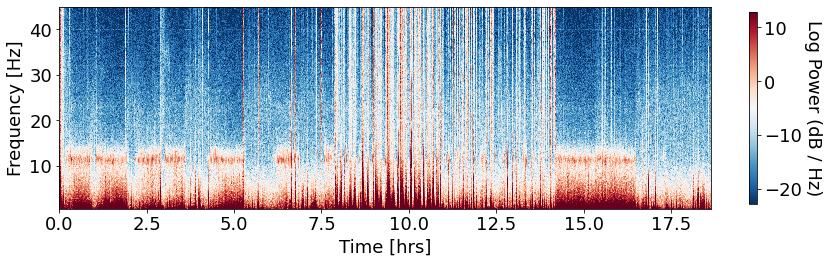

In [12]:
fig = plot_spectrogram(data[0], sf, fmax=45)
plt.tight_layout()
# plt.savefig(f'spectro {name}.png', dpi=100, bbox_inches='tight')
plt.show()

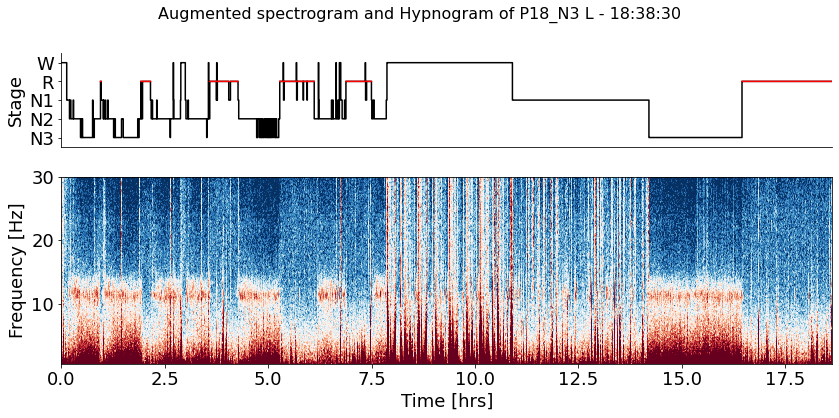

In [13]:
hypno = hypno_upsample_to_data(hypno=hypno_30s_aug, sf_hypno=(1/30), data=data, sf_data=sf)
fig = plot_spectrogram(data[0], sf, hypno=hypno, fmax=30, trimperc=5)
fig.suptitle(f'Augmented spectrogram and Hypnogram of {name} - {format_seconds_to_hhmmss(data.shape[1]/sf)}', fontsize=16)
plt.tight_layout()
# plt.savefig(f'spectro-hypno {name}.png', dpi=100, bbox_inches='tight')
plt.show()


In [14]:
hypno_30s_aug.shape

(2237,)

In [15]:
data_win_aug.shape

(2237, 7680)